In [1]:
import os
BASE_DIR = './runs'
import math
os.makedirs(BASE_DIR, exist_ok=True)
import random
import torch
import os
from tqdm.notebook import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from torch.nn.utils.rnn import pad_sequence
from utils import config
from data_utils import dataset
from model import vit
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from model.loss import ContrastiveLoss, ContrastiveSoftMax, CLIPLoss, NTXentLoss
import torch.nn.functional as F

#sets random
random_seed=42
random.seed(42)
torch.manual_seed(random_seed)
torch.backends.cudnn.benchmark=True
device="cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu" )

match device:
    case "cuda":
        torch.cuda.manual_seed_all(random_seed)
    case "mps":
        torch.mps.manual_seed(random_seed)

import gc
gc.collect()
torch.cuda.empty_cache()
conf = config.load_config("configs/stage_contrastive.yaml")

In [2]:
#GloVe
glove_file = 'glove.6B.300d.txt'
word2vec_temp_file = get_tmpfile("glove_word2vec.txt")
glove2word2vec(glove_file, word2vec_temp_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_temp_file)
class Tokenizer:
    def __init__(self, embeding_model):
        self.embeddings = embeding_model
    
    def tokenize(self, sent_tokens):
        tokens_embeddings = []
        for t in sent_tokens:
            if t in self.embeddings:
                tokens_embeddings.append(self.embeddings[t])
            else:
                tokens_embeddings.append(np.zeros(300))
        return torch.FloatTensor(tokens_embeddings)

tokenizer = Tokenizer(glove_model)

In [3]:

class LearnMetric(nn.Module):
    def __init__(self):
        super().__init__()
        self.metric_projector = nn.Sequential(
            nn.Linear(600, 600 * 3),
            nn.GELU(),
            nn.Linear(600 * 3, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.metric_projector(x)
        return x

In [4]:


l_metric = LearnMetric()
image_embeder = vit.ImgEncoder(**conf['model']['ImageEncoder'])
text_embeder = vit.TextConvEncoder(**conf['model']['TextConvEncoder'])
siam_model = vit.SiamEncoder(**conf['model']['SiamEncoder'])
siam_model_params = list(image_embeder.parameters()) + list(text_embeder.parameters()) + list(siam_model.parameters()) + list(l_metric.parameters())
optimizer = torch.optim.AdamW(siam_model_params,  **conf['optimizer_params'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.85)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1.0e-6, T_max=10000)
scaler = torch.cuda.amp.GradScaler()
losses = []
val_scores = []
(sum(p.numel() for p in image_embeder.parameters() if p.requires_grad), 
sum(p.numel() for p in text_embeder.parameters() if p.requires_grad), 
sum(p.numel() for p in siam_model.parameters() if p.requires_grad))

(1922460, 638100, 10921201)

In [5]:
import json
def save_metric(path_to_checkpoints_folder, checkpoint_name, l_metric):
    path_to_checkpoint = os.path.join(path_to_checkpoints_folder, checkpoint_name)
    path_to_model = os.path.join(path_to_checkpoint, 'metric_model.pt')
    torch.save(
        {
            'l_metric_state_dict': l_metric.state_dict()             
        },
        path_to_model
    )

def load_metric(path_to_checkpoints_folder, checkpoint_name, device):
    path_to_data = os.path.join(path_to_checkpoints_folder, checkpoint_name)
    path_to_model = os.path.join(path_to_data, 'metric_model.pt')
    model_state = torch.load(path_to_model, map_location=device)
    l_metric = LearnMetric()
    l_metric.load_state_dict(model_state['l_metric_state_dict'])
    return l_metric


def save_checkpoint(path_to_checkpoints_folder, checkpoint_name, conf, text_embedder, img_embedder, siam_model, optimizer, scheduler, scaler, train_losses, val_scores):
    """
    Save model, config, score
    """
    path_to_checkpoint = os.path.join(path_to_checkpoints_folder, checkpoint_name)
    os.makedirs(path_to_checkpoint, exist_ok=True)
    config.dump_config(path_to_checkpoint, conf, 'config.yaml')

    path_to_metrics = os.path.join(path_to_checkpoint, 'metrics.json')
    with open(path_to_metrics, 'w') as f:
        json.dump({'train_losses': train_losses, 'val_scores': val_scores}, f, indent=4)
    
    path_to_model = os.path.join(path_to_checkpoint, 'model.pt')
    torch.save(
                {
                    'text_embedder_state_dict': text_embedder.state_dict(),
                    'img_embedder_state_dict': img_embedder.state_dict(),
                    'siam_model_state_dict': siam_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    "scaler_state_dict": scaler.state_dict()
                
                },
                path_to_model
                )

def load_checkpoint(path_to_checkpoints_folder, checkpoint_name, device):
    path_to_data = os.path.join(path_to_checkpoints_folder, checkpoint_name)
    conf = config.load_config(os.path.join(path_to_data, 'config.yaml'))

    with open(os.path.join(path_to_data, 'metrics.json'), 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    val_scores = data['val_scores']

    path_to_model = os.path.join(path_to_data, 'model.pt')
    model_state = torch.load(path_to_model, map_location=device)
    image_embeder = vit.ImgEncoder(**conf['model']['ImageEncoder'])
    text_embeder = vit.TextConvEncoder(**conf['model']['TextConvEncoder'])
    siam_model = vit.SiamEncoder(**conf['model']['SiamEncoder'])
    scaler = torch.cuda.amp.GradScaler()
    image_embeder.load_state_dict(model_state['img_embedder_state_dict'])
    text_embeder.load_state_dict(model_state['text_embedder_state_dict'])
    siam_model.load_state_dict(model_state['siam_model_state_dict'])
    scaler.load_state_dict(model_state['scaler_state_dict'])


    image_embeder = image_embeder.to(device)
    text_embeder = text_embeder.to(device)
    siam_model = siam_model.to(device)

    siam_model_params = torch.nn.ModuleList([image_embeder, text_embeder, siam_model])
    optimizer = torch.optim.AdamW(siam_model_params.parameters(), **conf['optimizer_params'])
    # optimizer.load_state_dict(model_state['optimizer_state_dict'])

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 3, 0.8)
    return image_embeder, text_embeder, siam_model, optimizer, scheduler, conf, scaler, train_losses, val_scores

In [6]:
image_embeder, text_embeder, siam_model, optimizer, scheduler, conf, scaler, losses, val_scores = load_checkpoint(BASE_DIR, "epoch_14", device)
l_metric = load_metric(BASE_DIR, "epoch_14", device)
siam_model_params = torch.nn.ModuleList([image_embeder, text_embeder, siam_model])

In [6]:
SEQ_LEN = conf['model']['TextConvEncoder']['seq_len']

def tokenize_sent_batch(sents_batch):
    tokenized_sentences = []
    length_list = []
    for sent in sents_batch:
        sent_tokens = sent.strip().split()
        if len(sent_tokens) > SEQ_LEN:
            sent_tokens = sent_tokens[:SEQ_LEN]
        tokenized_sentences.append(tokenizer.tokenize(sent_tokens))
        length_list.append(len(sent_tokens))
    #pad sequences to Text Embeder len
    tokenized_sentences[0] = torch.concat((tokenized_sentences[0], torch.zeros(SEQ_LEN - length_list[0], 300)), dim=0)
    seqs = pad_sequence(tokenized_sentences, batch_first=True)
    return seqs, torch.tensor(length_list, dtype=torch.uint8)


def pading_sentences_fn(data):
    masks_tensors, sents = zip(*data)
    masks_tensors = torch.stack(masks_tensors)
    sents, lens = tokenize_sent_batch(sents)
    return masks_tensors, sents, lens


train_dataset = dataset.ReferenceDataset(
    **conf['data']['train'],
)
train_data_coco_plus = dataset.ReferenceDataset(
    **conf['data']['train_plus'],
)
union_train_dataset = ConcatDataset([train_dataset, train_data_coco_plus])
train_data = DataLoader(
    union_train_dataset,
    batch_size=conf['train_settings']['batch_size'],
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    num_workers=6,
    collate_fn=pading_sentences_fn
)

val_dataset = dataset.ReferenceDataset(
    **conf['data']['val'],
)
val_dataset_plus = dataset.ReferenceDataset(
    **conf['data']['val_plus'],
)
union_val_dataset = ConcatDataset([val_dataset, val_dataset_plus])
val_data = DataLoader(
    union_val_dataset,
    batch_size=conf['train_settings']['batch_size'],
    shuffle=False,
    pin_memory=True,
    drop_last=True,
    num_workers=6,
    collate_fn=pading_sentences_fn
)
epoch = (conf['train_settings']['start_epoch'], conf['train_settings']['epochs'])

In [7]:
class Trainer:
    def __init__(self, text_embedder, img_embedder, siam_model, optimizer, checkpoint_path, scheduler, conf, scaler, device="cpu", tb_path=None, l_metric=None):
        self.text_embedder = text_embedder.to(device)
        self.img_embedder = img_embedder.to(device)
        self.siam_model = siam_model.to(device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.tb_path = tb_path
        self.l_metric = l_metric.to(self.device)
        self.checkpoint_path = checkpoint_path
        self.loss_fn = CLIPLoss( temperature=1).to(device)
        # self.loss_fn = NTXentLoss(conf['train_settings']['batch_size'], temperature=0.8).to(device)
        # self.loss_fn = ContrastiveLoss(2.0).to(device)
        self.conf = conf
        self.scaler=scaler
        if self.tb_path is not None:
            self.writer =  SummaryWriter(self.checkpoint_path, self.tb_path)

    def train(self, train_data, val_data, epochs, losses, val_scores, checkpoint_step=1, scheduler_step=1, scaler_step=1):
        if self.tb_path is not None:
          for i, ls in enumerate(losses):
            self.writer.add_scalar("Loss_epoche/train", ls, i)
          for i, vl in enumerate(val_scores):
            self.writer.add_scalar("MSE/val", vl, i)
        for epoch in tqdm(range(epochs[0], epochs[1]), desc='Epochs'):
            train_loss = self.train_epoch(train_data, epoch, scaler_step)
            val_acc, cosine_acc, snx_loss = self.validate(val_data)
            if self.tb_path is not None:
                self.writer.add_scalar("Cosine/val", cosine_acc , epoch )
                self.writer.add_scalar("Loss_epoche/train", train_loss, epoch)
                self.writer.add_scalar("MSE/val", val_acc, epoch)
                self.writer.add_scalar("SN-XTENT/val", snx_loss, epoch)
            print(f"Epoch: {epoch}/{epochs} - Loss: {train_loss:.4f}")
            losses.append(train_loss)
            val_scores.append(val_acc)
            if (epoch + 1) % scheduler_step == 0:
                self.scheduler.step()
            if (epoch + 1) % checkpoint_step == 0 and epoch != 0:
                self.conf['train_settings']['start_epoch'] = epoch + 1
                save_checkpoint(
                    self.checkpoint_path,
                    f'epoch_{epoch}',
                    self.conf,
                    self.text_embedder,
                    self.img_embedder,
                    self.siam_model,
                    self.optimizer,
                    self.scheduler,
                    self.scaler,
                    losses,
                    val_scores
                    )
                save_metric(
                    self.checkpoint_path,
                    f'epoch_{epoch}',
                    self.l_metric
                )

    def train_epoch(self, train_data, epoch, scaler_step):
        self.img_embedder.train()
        self.text_embedder.train()
        self.siam_model.train()
        img_embedder = torch.compile(self.img_embedder, mode='max-autotune', fullgraph=True)
        text_embedder = torch.compile(self.text_embedder, mode='max-autotune', fullgraph=True)
        siam_model = torch.compile(self.siam_model, mode='max-autotune', fullgraph=True)
        # img_embedder = self.img_embedder
        # text_embedder = self.text_embedder
        # siam_model = self.siam_model
        loss = []
        self.optimizer.zero_grad()
        for step, (masks_tensor, sents, _) in enumerate(tqdm(train_data, desc="Training", leave=False)):
            #calc step
            with torch.autocast(device_type=self.device):
                masks_tensor = masks_tensor.to(self.device, non_blocking=True)
                sents = sents.to(self.device, non_blocking=True)
                # labels = labels.to(self.device, non_blocking=True)
                img_embeddings = img_embedder(masks_tensor)
                text_embeddings = text_embedder(sents)
                img_encoded, _ = siam_model(img_embeddings)
                text_encoded, _ = siam_model(text_embeddings)
                # img_encoded = F.normalize(img_encoded)
                # text_encoded = F.normalize(text_encoded)
                # logits = img_encoded @ text_encoded.T
                l = torch.stack((img_encoded, text_encoded))
                logits = l[:, torch.cartesian_prod(torch.arange(l.shape[1]), torch.arange(l.shape[1]))]
                logits = logits.view(l.shape[0], l.shape[1], l.shape[1], -1)[0]
                logits = self.l_metric(logits).squeeze()
                step_loss = self.loss_fn(logits)
                # step_loss = self.loss_fn(img_encoded, text_encoded)
            self.scaler.scale(step_loss).backward()
            # step_loss.backward()
            if (step + 1) % scaler_step == 0:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                # self.optimizer.step()
                self.optimizer.zero_grad()
            step_loss = step_loss.cpu().detach().item()
            loss.append(step_loss)
            if self.tb_path is not None:
                self.writer.add_scalar("Contrastive_loss/train", step_loss, epoch * len(train_data) + step)
        return np.mean(loss)


    @torch.no_grad()
    def validate(self, val_data):
        self.img_embedder.eval()
        self.text_embedder.eval()
        self.siam_model.eval()
        mse_acc = []
        coss_acc = []
        snx = []
        mse = torch.nn.functional.mse_loss
        cos_los = torch.nn.functional.cosine_similarity
        csm_loss = CLIPLoss(temperature=1).to(self.device)
        # csm_loss = NTXentLoss(conf['train_settings']['batch_size'], temperature=0.8).to(self.device)
        # csm_loss = ContrastiveLoss(2.0).to(device)
        for _, (masks_tensor, sents, _) in enumerate(tqdm(val_data, desc="Validating", leave=False)):
            with torch.autocast(device_type=self.device):
                masks_tensor = masks_tensor.to(self.device, non_blocking=True)
                sents = sents.to(self.device, non_blocking=True)
                # labels = labels.to(self.device, non_blocking=True)
                img_embeddings = self.img_embedder(masks_tensor)
                text_embeddings = self.text_embedder(sents)
                img_encoded, _ = self.siam_model(img_embeddings)
                text_encoded, _ = self.siam_model(text_embeddings)
                mse_loss = mse(img_encoded, text_encoded)
                cs = torch.mean(cos_los(img_encoded, text_encoded))
                # img_encoded = F.normalize(img_encoded)
                # text_encoded = F.normalize(text_encoded)
                # logits = img_encoded @ text_encoded.T
                l = torch.stack((img_encoded, text_encoded))
                logits = l[:, torch.cartesian_prod(torch.arange(l.shape[1]), torch.arange(l.shape[1]))]
                logits = logits.view(l.shape[0], l.shape[1], l.shape[1], -1)[0]
                logits = self.l_metric(logits).squeeze()
                csm = csm_loss(logits)
                # csm = csm_loss(img_encoded, text_encoded)
                snx.append(csm.cpu().detach().item())
                coss_acc.append(cs.cpu().detach().item())
                mse_acc.append(mse_loss.cpu().detach().item())
                snx.append(csm.cpu().detach().item())
        return np.mean(mse_acc), np.mean(coss_acc), np.mean(snx)

In [8]:
trainer = Trainer(text_embeder, image_embeder, siam_model, optimizer, BASE_DIR, scheduler, conf, scaler, device, 'tb', l_metric=l_metric)
gc.collect()
torch.cuda.empty_cache()

In [9]:
trainer.train(train_data, val_data, epoch, losses, val_scores, scaler_step=conf['train_settings']['scaler_step'], checkpoint_step=5)

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/1881 [00:00<?, ?it/s]

W0623 19:26:23.670000 140691392778240 torch/_inductor/utils.py:945] [0/0] not enough SMs to use max_autotune_gemm mode
AUTOTUNE addmm(10170x1200, 10170x300, 300x1200)
  addmm 0.3860 ms 100.0%
  bias_addmm 0.3948 ms 97.8%
SingleProcess AUTOTUNE takes 0.4816 seconds
AUTOTUNE addmm(45x300, 45x300, 300x300)
  bias_addmm 0.0113 ms 100.0%
  addmm 0.0133 ms 84.6%
SingleProcess AUTOTUNE takes 0.2241 seconds
AUTOTUNE addmm(1170x1200, 1170x300, 300x1200)
  addmm 0.0758 ms 100.0%
  bias_addmm 1.0757 ms 7.0%
SingleProcess AUTOTUNE takes 0.3693 seconds


### METRICS

In [14]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import matplotlib.pyplot as plt

In [39]:
@torch.no_grad
def calc_cosine_and_euclid(test_dataloader, img_encoder, text_encoder, siam_model):
    img_encoder.eval()
    text_encoder.eval()
    siam_model.eval()
    cos_metric = []
    l2_metric = []
    for _, (_, _, _, masks_tensor, sents, _) in enumerate(tqdm(test_dataloader, desc="Cos similarity", leave=False)):
        masks_tensor = masks_tensor.to(device=device, non_blocking=True)
        sents = sents.to(device=device, non_blocking=True)
        image_embeddings = img_encoder(masks_tensor)
        text_embeddings = text_encoder(sents)
        img_encoded, _ = siam_model(image_embeddings)
        text_encoded, _ = siam_model(text_embeddings)
        cos_metric.append(torch.mean(F.cosine_similarity(img_encoded, text_encoded)).item())
        l2_metric.append(torch.mean(F.pairwise_distance(img_encoded, text_encoded)).item())
    return np.mean(cos_metric), np.mean(l2_metric)

@torch.no_grad
def calc_perm_accuracy(test_dataloader, img_encoder, text_encoder, siam_model):
    img_encoder.eval()
    text_encoder.eval()
    siam_model.eval()
    l_metric.eval()
    perm = []
    for _, (_, _, _, masks_tensor, sents, _) in enumerate(tqdm(test_dataloader, desc="Cos similarity", leave=False)):
        masks_tensor = masks_tensor.to(device=device, non_blocking=True)
        sents = sents.to(device=device, non_blocking=True)
        image_embeddings = img_encoder(masks_tensor)
        text_embeddings = text_encoder(sents)
        img_encoded, _ = siam_model(image_embeddings)
        text_encoded, _ = siam_model(text_embeddings)
        # l = torch.stack((img_encoded, text_encoded))
        # logits = l[:, torch.cartesian_prod(torch.arange(l.shape[1]), torch.arange(l.shape[1]))]
        # logits = logits.view(l.shape[0], l.shape[1], l.shape[1], -1)[0]
        # logits = l_metric(logits).squeeze()
        logits = torch.pairwise_distance(img_encoded, text_encoded.expand(img_encoded.shape[0], -1))
        # logits = img_encoded @ text_encoded.T
        metric = torch.sum(torch.argmax(logits, dim=1).to(device=logits.device) == torch.arange(logits.shape[1]).to(device=logits.device)) / logits.shape[1]
        perm.append(metric.item())
    return np.mean(perm)

def extract_segments(seg_mask: torch.Tensor, seg_info: list[dict], image: torch.Tensor) -> torch.Tensor:
    """
    Extracting segments from given image corresponding segmentation mask
    """
    #creating and concating maps for each class, reshaping [height, width] -> [1, height, width] 
    class_maps = torch.cat([seg_mask[None, :, :] == value['id'] for value in seg_info], dim=0)
    class_maps = class_maps.to(torch.uint8)

    # edding extra dimension for extracting from image [seg_mask_for_class, height, width] -> [seg_mask_for_class, chnnels ,height, width]
    class_maps = class_maps[:, None, :, :]
    class_maps = class_maps.repeat(1, 3, 1, 1)
    extracted_segments = image * class_maps
    return extracted_segments

In [83]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation

feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-coco").to(device)
image_embeder, text_embeder, siam_model, optimizer, scheduler, conf, scaler, losses, val_scores = load_checkpoint(BASE_DIR, "epoch_29_170", device)
# l_metric = load_metric(BASE_DIR, "epoch_29", device)
image_embeder = image_embeder.to(device)
text_embeder = text_embeder.to(device)
siam_model =  siam_model.to(device)
# l_metric = l_metric.to(device)

In [84]:
def pading_test_sentences_fn(data):
    image, tensor_img, tensor_mask, train_mask, sents = zip(*data)
    train_mask = torch.stack(train_mask)
    tokenized_sents, lens = tokenize_sent_batch(sents)
    tensor_img = torch.stack(tensor_img)
    tensor_mask = torch.stack(tensor_mask)
    return image, tensor_img, tensor_mask, train_mask, tokenized_sents, sents


test_dataset = dataset.ReferenceDataset(
    **conf['data']['test'],
)
test_data_coco_plus = dataset.ReferenceDataset(
    **conf['data']['test_plus'],
)
union_test_dataset = ConcatDataset([test_dataset, test_data_coco_plus])
test_data = DataLoader(
    union_test_dataset,
    batch_size=10,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=4,
    collate_fn=pading_test_sentences_fn
)


In [85]:
cos, euc = calc_cosine_and_euclid(test_data, image_embeder, text_embeder, siam_model)
cos, euc

Cos similarity:   0%|          | 0/395 [00:00<?, ?it/s]

(0.998983465418031, 1.038143159166167)

In [89]:
p = calc_perm_accuracy(test_data, image_embeder, text_embeder, siam_model)
p

Cos similarity:   0%|          | 0/395 [00:00<?, ?it/s]

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [46]:
a = ["the police officier on the horse", "the lady in blue shirt", "flying child", "bird"]
b, _ = tokenize_sent_batch(a)
b = b.to(device)
text_embeddings = text_embeder(b)
text_encoded, _ = siam_model(text_embeddings)
l = torch.stack((text_encoded, text_encoded))
logits = l[:, torch.cartesian_prod(torch.arange(l.shape[1]), torch.arange(l.shape[1]))]
logits = logits.view(l.shape[0], l.shape[1], l.shape[1], -1)[0]
logits = l_metric(logits).squeeze()

In [38]:
logits, torch.argmax(logits, dim=1)

(tensor([[ 0.9713,  0.6301,  0.9616, -0.8716],
         [ 0.6389,  0.9715,  0.9033,  0.9247],
         [ 0.9624,  0.9028,  0.9720, -0.1062],
         [-0.8686,  0.9241, -0.1077,  0.9719]], device='cuda:0',
        grad_fn=<SqueezeBackward0>),
 tensor([0, 1, 2, 3], device='cuda:0'))

In [90]:
@torch.no_grad
def calc_acc(test_dataloader, img_encoder, text_encoder, siam_model, l_metric):
    img_encoder.eval()
    text_encoder.eval()
    siam_model.eval()
    l_metric.eval()
    acc = []

    for _, (images, tensor_img, tensor_mask,  _, sents, _) in enumerate(tqdm(test_dataloader, desc="segment acc", leave=False)):
        tensor_mask = tensor_mask.to(device=device, non_blocking=True)
        tensor_img = tensor_img.to(device=device, non_blocking=True)
        sents = sents.to(device=device, non_blocking=True)
        inputs = feature_extractor(images=images, return_tensors="pt")
        for k in inputs:
            inputs[k] = inputs[k].to(device)
        outputs = model(**inputs)
        result = feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[images[0].shape[:2]]*tensor_img.shape[0])
        for i, image in enumerate(images):
            segments = extract_segments(result[i]['segmentation'], result[i]['segments_info'], image=tensor_img[i].to(device))
            cur_sent = sents[i].unsqueeze(0)
            image_embeddings = img_encoder(segments)
            text_embeddings = text_encoder(cur_sent)
            img_encoded, _ = siam_model(image_embeddings)
            text_encoded, _ = siam_model(text_embeddings)
            logits = torch.pairwise_distance(img_encoded, text_encoded.expand(img_encoded.shape[0], -1))
            # logits = torch.cat((img_encoded, text_encoded.expand(img_encoded.shape[0], -1)), dim = 1)
            # logits = l_metric(logits).squeeze()
            pos = torch.argmax(logits)
            seg_mask = torch.where(result[i]['segmentation'] == (pos + 1), 1, 0)
            intersection = torch.sum(seg_mask * tensor_mask[i])
            union = torch.sum(seg_mask) + torch.sum(tensor_mask[i]) - intersection
            acc.append((intersection / union).item())
        # image_embeddings = img_encoder(masks_tensor)
        # text_embeddings = text_encoder(sents)
        # img_encoded, _ = siam_model(image_embeddings)
        # text_encoded, _ = siam_model(text_embeddings)
        # l = torch.stack((img_encoded, text_encoded))
        # logits = l[:, torch.cartesian_prod(torch.arange(l.shape[1]), torch.arange(l.shape[1]))]
        # logits = logits.view(l.shape[0], l.shape[1], l.shape[1], -1)[0]
        # logits = l_metric(logits).squeeze()
        # metric = torch.sum(torch.argmax(logits, dim=1).to(device=logits.device) == torch.arange(logits.shape[1]).to(device=logits.device)) / logits.shape[1]
        # acc.append(metric.item())
    return np.mean(acc)

In [91]:
calc_acc(test_data, image_embeder, text_embeder, siam_model, l_metric)

segment acc:   0%|          | 0/395 [00:00<?, ?it/s]

`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. N

2.0946744194957914

In [8]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [20]:
image, tensor_img, tensor_mask, train_mask, sents = union_test_dataset[10]
inputs = feature_extractor(images=image, return_tensors="pt")
for k in inputs:
    inputs[k] = inputs[k].to(device)
outputs = model(**inputs)
result = feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[image.shape[:2]])[0]
masks = extract_segments(result['segmentation'], result['segments_info'], tensor_img.to(device))

`label_ids_to_fuse` unset. No instance will be fused.


TypeError: expected Tensor as element 0 in argument 0, but got bool

### Test imgs

In [24]:
import cv2 as cv
import matplotlib.pyplot as plt
from data_utils.dataset import affine_transform
device = 'cuda'

In [25]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation

feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-coco").to(device)
image_embeder, text_embeder, siam_model, optimizer, scheduler, conf, scaler, losses, val_scores = load_checkpoint(BASE_DIR, "epoch_14", device)
l_metric = load_metric(BASE_DIR, "epoch_14", device)
image_embeder = image_embeder.to(device)
text_embeder = text_embeder.to(device)
siam_model =  siam_model.to(device)
l_metric = l_metric.to(device)

In [27]:
def prepare_img(path):
    img = cv.imread(path)
    img_arr = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    transformed_image =  affine_transform(img_arr, (224, 224))
    tensor_img = torch.from_numpy(transformed_image.transpose(2, 0, 1)).to(torch.float32)
    return tensor_img.div_(255) 

In [53]:
img = prepare_img('./test_images/imgs/7.jpg')
sents = ["drawing means of transportation",]
sents, _ = tokenize_sent_batch(sents)
sents = sents.to(device)


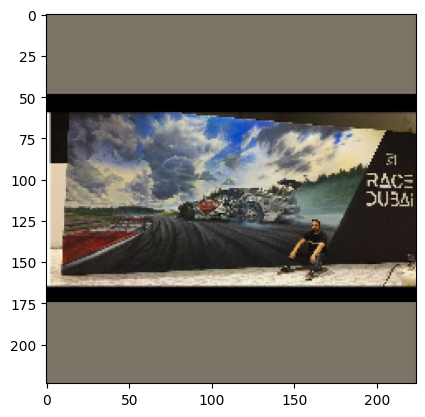

In [54]:
ax = plt.gca()
ax.imshow(img.permute(1, 2, 0))

In [55]:
inputs = feature_extractor(images=img, return_tensors="pt")
for k in inputs:
    inputs[k] = inputs[k].to(device)
outputs = model(**inputs)
result = feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[img.shape[:2]])

`label_ids_to_fuse` unset. No instance will be fused.


In [56]:
result[0]['segments_info']

[]

In [40]:
segments = extract_segments(result[0]['segmentation'], result[0]['segments_info'], image=img)
cur_sent = sents.unsqueeze(0)
image_embeddings = image_embeder(segments)
text_embeddings = text_embeder(cur_sent)
img_encoded, _ = siam_model(image_embeddings)
text_encoded, _ = siam_model(text_embeddings)
logits = torch.cat((img_encoded, text_encoded.expand(img_encoded.shape[0], -1)), dim = 1)
logits = l_metric(logits).squeeze()
pos = torch.argmax(logits)
pos, logits

RuntimeError: torch.cat(): expected a non-empty list of Tensors